The Hadamard test is performed using a register with an ancilla qubit in the $|0\rangle$ state and a prepared quantum state $|\psi\rangle$, the following circuit can be used to extract the expecation value from measurement of the ancilla
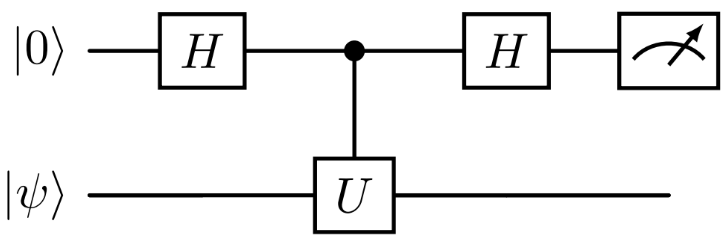
The key insight is that
$$P(0) = \frac{1}{2} [I+Re\langle\psi|O|\phi\rangle]$$
and  
$$P(1) = \frac{1}{2} [I-Re\langle\psi|O|\phi\rangle]$$
so their difference is equal to  
$$P(0)-P(1) = Re\langle\psi|O|\phi\rangle$$

이는 복잡한 양자 상태를 직접 측정하지 않고도, 유니터리 연산자의 기댓값을 추정할 수 있음을 제시  

What if you want to perform the Hadamard test to compute an expectation value like $\langle\psi|O|\phi\rangle$, where $|\psi\rangle$ and $|\phi\rangle$ are different states and $O$ is a Pauli Operator? This is a common subroutine for the QKSD, where matrix elements are determined by computing expectation values b/w different states  

Defining $O$ as 
$$O=X_1 X_2$$
and given the fact that
$$|\psi\rangle = U_\theta | 0\rangle \qquad  |\phi\rangle=U_\phi|0\rangle$$
we can combine the state preparation steps into the operator resulting in 
$$\langle \psi|O|\phi\rangle = \langle|U_\theta^\dagger O U_\phi | 0\rangle$$
which corresponeds to the following circuit.
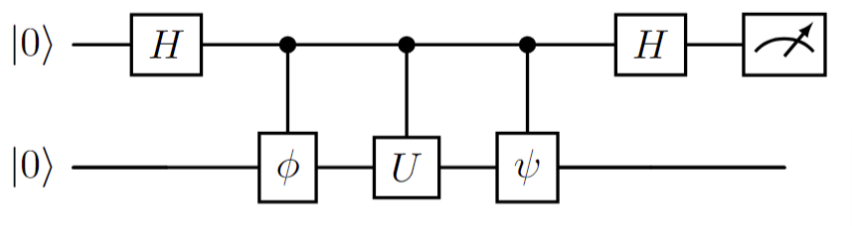
By preparing this circuit, and repeatedly measuring the ancilla qubit, we estimate the expectation value as  
$$P(0)-P(1) = Re\langle\psi|O|\phi\rangle$$

## Numerical result as a reference

In [1]:
import cudaq
import numpy as np
from functools import reduce

cudaq.set_target('nvidia')

qubit_num = 2


@cudaq.kernel
def psi(num: int):
    q = cudaq.qvector(num)
    h(q[1])


@cudaq.kernel
def phi(n: int):
    q = cudaq.qvector(n)
    x(q[0])

psi_state = cudaq.get_state(psi, qubit_num)
print('Psi state: ', psi_state)

phi_state = cudaq.get_state(phi, qubit_num)
print('Phi state: ', phi_state)

Psi state:  SV: [(0.707107,0), (0,0), (0.707107,0), (0,0)]

Phi state:  SV: [(0,0), (1,0), (0,0), (0,0)]



The Hamiltonian operator is defined as a CUDA-Q spin operator and converted to a matrix

In [2]:
ham = cudaq.spin.x(0) * cudaq.spin.x(1)
ham_matrix = ham.to_matrix()
print('hamiltonian: ', np.array(ham_matrix), '\n')

exp_val = reduce(np.dot, (np.array(psi_state).conj().T, ham_matrix, phi_state))
# reduce(function, iterable) 함수는 시퀀스의 모든 요소에 대해 function을 누적적으로 적용하여 단일 결과를 반환함
print('Numerical expectation value: ', exp_val)

hamiltonian:  [[0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j]] 

Numerical expectation value:  (0.7071067690849304+0j)


## Using ```Sample``` to perform the Hadamard test

In [3]:
import cudaq

cudaq.set_target('nvidia')


@cudaq.kernel
def U_psi(q: cudaq.qview):
    h(q[1])


@cudaq.kernel
def U_phi(q: cudaq.qview):
    x(q[0])


@cudaq.kernel
def ham_cir(q: cudaq.qview):
    x(q[0])
    x(q[1])


@cudaq.kernel
def kernel(n: int):
    ancilla = cudaq.qubit()
    q = cudaq.qvector(n)
    h(ancilla)
    cudaq.control(U_phi, ancilla, q)
    cudaq.control(ham_cir, ancilla, q)
    cudaq.control(U_psi, ancilla, q)

    h(ancilla)

    mz(ancilla)

In [4]:
shots = 100000
qubit_num = 2
count = cudaq.sample(kernel, qubit_num, shots_count=shots)
print(count)

mean_val = (count['0'] - count['1']) / shots
error = np.sqrt(2 * count['0'] * count['1'] / shots) / shots
print('Observable QC: ', mean_val, '+ -', error)
print('Numerical result', np.real(exp_val))

{ 0:85269 1:14731 }

Observable QC:  0.70538 + - 0.0015849906239470315
Numerical result 0.7071067690849304


## Multi-GPU evaluation of QKSD matrix elements using the Hadamard Test